# Generic Vision Backbone → Fastai Regression Head (Valence–Arousal)

This notebook provides a template for training a small regression head on top of a **frozen, pretrained vision backbone** for **valence–arousal (V-A)** prediction. 🧠

It's designed to be flexible and supports loading backbones from both **Hugging Face Transformers** (like `DINOv3`) and the **`timm` library** (like `ResNet` or `EfficientNet`), allowing for easy experimentation.

* Targets are expected in **FindingEmo** units: $V \in [-3,3]$, $A \in [0,6]$.
* For training, we map targets to a bipolar space: $v_{ref} = v/3$ and $a_{ref} = (a−3)/3$, which maps both to the range $[-1,1]$.
* We report **Mean Absolute Error (MAE)**, **Concordance Correlation Coefficient (CCC)**, and **Spearman’s ρ** on the test set.
* The backbone remains **frozen**; only the lightweight regression head is trained.

In [1]:
# --- Install latest libraries (uncomment if needed) ---
# %pip install -U torch torchvision torchaudio
# %pip install -U fastai transformers timm torchmetrics datasets
# %pip install -U accelerate
#
# If you're on Apple Silicon and want MPS acceleration, make sure your PyTorch build supports MPS.
# See: https://pytorch.org/get-started/locally/


# Import Libs

In [2]:
from __future__ import annotations

import os, math, random, shutil, json
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
import math
import timm

# Fastai
from fastai.vision.all import *
from fastai.learner import load_learner
from fastai.callback.tracker import CSVLogger, EarlyStoppingCallback

from PIL import Image, ImageOps
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings

warnings.filterwarnings("ignore", message="image file is truncated")

# Metrics
from torchmetrics.functional.regression import concordance_corrcoef as ccc_fn
# (Spearman is computed later in the test block)

# Device (prefers Apple MPS on M-series Macs)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device


device(type='mps')

In [3]:
# Load environment variables
from dotenv import load_dotenv

load_dotenv()

# Set HuggingFace token for authentication
if "HUGGINGFACE_TOKEN" in os.environ:
    from huggingface_hub import login

    login(token=os.environ["HUGGINGFACE_TOKEN"])

# Config

## Model Selection (HF or timm)

- Source: set `BACKBONE_SRC` to `\"hf\"` (HuggingFace Transformers) or `\"timm\"` (timm/torchvision).
- Name: set `MODEL_NAME` to a valid id for the chosen source.
  - HF examples: `facebook/dinov3-vitb16-pretrain-lvd1689m`, `google/vit-base-patch16-224`.
  - timm examples: `resnet50`, `resnet18`, `efficientnet_b0`, `convnext_tiny`.
- Transforms:
  - HF: letterbox to `(W,H)` then normalize via the HF image processor.
  - timm: deterministic eval transform (Resize+CenterCrop+Normalize) matching the model’s config.
- Everything else (DataBlock, LR finder, training, learning curve, metrics, test eval, saving) stays identical.

Notes:
- If using timm backbones, ensure `timm` and `torchvision` are installed.
- To switch: change `BACKBONE_SRC` and `MODEL_NAME` below; re-run the \"Load Backbone\" and subsequent cells.

Install (fish shell):
- `source .venv/bin/activate.fish`
- `uv pip install timm torchvision`


> To train a ResNet or EfficientNet model, modify below:

+ Set BACKBONE_SRC to "timm".
+ Set MODEL_NAME to the desired model, for example, "resnet50" or "efficientnet_b0".

In [4]:
# Find all ResNet models
resnet_models = timm.list_models("*resnet*")
print(resnet_models)

# Find all pretrained EfficientNet models
# effnet_models = timm.list_models('efficientnet*', pretrained=True)
# print(effnet_models)

['cspresnet50', 'cspresnet50d', 'cspresnet50w', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'gcresnet33ts', 'gcresnet50t', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_ecaresnet26', 'nf_ecaresnet50', 'nf_ecaresnet101', 'nf_resnet26', 'nf_resnet50', 'nf_resnet101', 'nf_seresnet26', 'nf_seresnet50', 'nf_seresnet101', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_clip', 'resnet50_clip_gap', 'resnet50_gn', 'resnet50_mlp', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet50x4_clip', 'resnet50x4_clip_gap', 'resnet50x16_clip', 'resnet50x16_clip_gap', 'resnet50x64_clip', 'resnet5

In [ ]:
# Select backbone source: 'hf' (Transformers) or 'timm' (timm/torchvision)
BACKBONE_SRC = "timm"
MODEL_NAME = "resnet50"  # "facebook/dinov3-vitb16-pretrain-lvd1689m"
BASE_W, BASE_H = 800, 600  # For timm models, this is automatically detected
BATCH_SIZE = 32
NUM_WORKERS = 8
EPOCHS = 20

# Use only a fraction of the dataset for faster experiments
DATA_FRACTION = 0.1  # Only downsamples Training Data
SAMPLE_SEED = 2025


# Resolve project root robustly (searches upward for a 'data' directory)
def _find_project_root(start: Path | None = None) -> Path:
    p = Path.cwd() if start is None else Path(start).resolve()
    for _ in range(6):
        if (p / ".git").exists() or (p / "data").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd()


PROJECT_ROOT = _find_project_root()
DATA_ROOT = PROJECT_ROOT / "data"  # FindingEmo dataset root

# Ensure CSV splits exist (train/valid/test) by invoking the split script if needed
_train_csv = DATA_ROOT / "train.csv"
_valid_csv = DATA_ROOT / "valid.csv"
_test_csv = DATA_ROOT / "test.csv"
if not (_train_csv.exists() and _valid_csv.exists() and _test_csv.exists()):
    import importlib.util as _ilu

    split_path = PROJECT_ROOT / "scripts" / "create_train_val_test_splits.py"
    if not split_path.exists():
        raise FileNotFoundError(f"Split script not found: {split_path}")
    spec = _ilu.spec_from_file_location("create_splits_mod", split_path)
    mod = _ilu.module_from_spec(spec)
    assert spec and spec.loader, "Unable to load split script"
    spec.loader.exec_module(mod)
    mod.create_splits()

# Load these paths in subsequent cells
CSV_TRAIN = _train_csv  # CSV with columns: image_path,valence,arousal
CSV_VALID = _valid_csv  # Validation split
CSV_TEST = _test_csv  # Test split


# Load Backbone (HF or timm)


In [6]:
# Unified backbone loader: HF (Transformers) or timm/torchvision
from types import SimpleNamespace

processor = None

if BACKBONE_SRC == "hf":
    from transformers import AutoImageProcessor, AutoModel

    processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
    backbone = AutoModel.from_pretrained(MODEL_NAME)
    for p in backbone.parameters():
        p.requires_grad = False
    backbone = backbone.to(device)
    backbone.eval()

elif BACKBONE_SRC == "timm":
    import timm
    from timm.data import resolve_data_config

    tv_backbone = timm.create_model(
        MODEL_NAME, pretrained=True, num_classes=0, global_pool="avg"
    )
    tv_backbone.eval().to(device)

    class TimmBackboneWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, pixel_values):
            feats = self.model(pixel_values)
            return SimpleNamespace(pooler_output=feats, last_hidden_state=None)

    backbone = TimmBackboneWrapper(tv_backbone)

    cfg = resolve_data_config({}, model=tv_backbone)

else:
    raise ValueError(f"Unsupported BACKBONE_SRC: {BACKBONE_SRC}")

# Determine feature dimension without dummy forward
if BACKBONE_SRC == "hf":
    # Most HF vision backbones expose hidden_size
    feat_dim = getattr(getattr(backbone, "config", None), "hidden_size", None)
    if feat_dim is None:
        # Fallback: try common attributes
        feat_dim = getattr(backbone, "hidden_size", None)
        if feat_dim is None:
            raise RuntimeError("Unable to determine feature dim from config")
else:
    # timm models typically expose num_features or classifier in_features
    tv = getattr(backbone, "model", backbone)
    feat_dim = getattr(tv, "num_features", None)
    if feat_dim is None:
        try:
            clf = tv.get_classifier()
            feat_dim = getattr(clf, "in_features", None)
        except Exception:
            pass
    if feat_dim is None:
        raise RuntimeError("Unable to determine timm feature dim")
feat_dim


2048

## Why Change Scale?


+ Balanced targets: Valence is −3..3 and Arousal is 0..6. A simple head works best when both targets live on the same bounded range. Mapping both to [-1,1] makes losses comparable and gradients stable.  

+ Match the head: A tanh head naturally outputs [-1,1]. If labels aren’t in that range, the head must learn offsets/scales, which slows learning and can saturate activations.  

+ Stable training with tanh: Using [-1,1] targets with a tanh head avoids saturation and keeps gradients stable, while evaluation is still reported back in FE units.

## How We Scale

+ Forward (to train): v_ref = v / 3 maps −3..3 → −1..1; a_ref = (a − 3) / 3 maps 0..6 → −1..1.  

+ Backward (to report): v = 3·v_ref; a = 3·a_ref + 3.  

+ Head: Adds tanh so predictions are already in [-1,1]. We train with plain MSE on these bipolar targets.


In [7]:
def fe_to_ref(va: Tensor) -> Tensor:
    "Map FindingEmo V∈[-3,3], A∈[0,6] -> bipolar space [-1,1]"
    v = va[..., 0] / 3.0
    a = (va[..., 1] - 3.0) / 3.0
    return torch.stack([v, a], dim=-1)


def ref_to_fe(va_ref: Tensor) -> Tensor:
    "Inverse map: bipolar [-1,1] -> FindingEmo units"
    v = va_ref[..., 0] * 3.0
    a = va_ref[..., 1] * 3.0 + 3.0
    return torch.stack([v, a], dim=-1)


# CCC utilities are included via torchmetrics; training uses MSE,
# and evaluation reports MAE, CCC, and Spearman.


# Load FindingEmo dataset

In [8]:
df_train = pd.read_csv(CSV_TRAIN)
df_valid = pd.read_csv(CSV_VALID)
df_test = pd.read_csv(CSV_TEST)

# Optionally downsample only the TRAIN split to a fraction; keep valid/test full
if DATA_FRACTION is not None and DATA_FRACTION < 1.0:
    df_train = df_train.sample(frac=DATA_FRACTION, random_state=SAMPLE_SEED)

# Filter out any rows whose image files are missing on disk (robust to CWD)
from pathlib import Path as _Path


def _exists_from_root(p):
    p = _Path(p)
    if not p.is_absolute():
        p = PROJECT_ROOT / p
    return p.exists()


def _filter_existing(df):
    m = df["image_path"].apply(_exists_from_root)
    dropped = int((~m).sum())
    if dropped:
        print(f"Dropped {dropped} rows due to missing files")
    return df.loc[m].reset_index(drop=True)


df_train = _filter_existing(df_train)
df_valid = _filter_existing(df_valid)
df_test = _filter_existing(df_test)

# Prune unreadable/corrupt images (keep truncated files loadable)
from fastai.vision.utils import verify_images
from pathlib import Path


def _abs_path(p):
    p = Path(p)
    return p if p.is_absolute() else (PROJECT_ROOT / p)


def prune_corrupt_rows(df):
    fns = [_abs_path(p) for p in df["image_path"].tolist()]
    bad = verify_images(fns)
    if len(bad):
        bad_abs = {str(p.resolve()) for p in bad}

        def keep(p):
            q = _abs_path(p).resolve()
            return str(q) not in bad_abs

        before = len(df)
        df = df[df["image_path"].apply(keep)].reset_index(drop=True)
        print(f"Removed {before - len(df)} corrupt images")
    return df


df_train = prune_corrupt_rows(df_train)
df_valid = prune_corrupt_rows(df_valid)
# df_test  = prune_corrupt_rows(df_test)  # optionally prune test

# Show a peek
len(df_train), len(df_valid), len(df_test), df_train.head(2)

Dropped 51 rows due to missing files
Dropped 142 rows due to missing files
Dropped 174 rows due to missing files


/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


(1331,
 2819,
 2787,
                                                                                                       image_path  \
 0                                                                    data/Run_2/Adoring toddlers war/whisper.jpg   
 1  data/Run_2/Outraged twenty-something shop/213985-then-and-now-gop-lawmakers-evolution-on-the-capitol-riot.jpg   
 
    valence  arousal  
 0       -1        2  
 1        0        2  )

## Data Preprocessing

In [9]:
# =======================
# Fastai transform: apply HF processor per item
# Aspect-preserving resize to ~800x600 then pad (letterbox)
# =======================
# =======================
# Fastai transform: delegate to HF processor (resize/crop/normalize)
# =======================
class HFProcessorTransform(Transform):
    def __init__(self, processor, target_size=None, normalize=False, rescale=True):
        # target_size is (W, H) in pixels or None to use defaults
        self.processor = processor
        self.target_size = target_size
        self.normalize = (
            normalize  # keep False for showable images; apply in batch_tfms instead
        )
        self.rescale = rescale
        # cache mean/std for decoding (if provided by the processor)
        self._mean = getattr(processor, "image_mean", None)
        self._std = getattr(processor, "image_std", None)

    def encodes(self, img: PILImage):
        # Ensure we hand a real PIL.Image to the HF processor
        if hasattr(img, "to_image"):
            pil = img.to_image()
        elif isinstance(img, Image.Image):
            pil = img
        else:
            import numpy as np

            pil = Image.fromarray(np.array(img))
        kwargs = dict(return_tensors="pt")
        # Ensure values are in [0,1] here and move normalization to batch_tfms
        kwargs.update(dict(do_normalize=self.normalize, do_rescale=self.rescale))
        if self.target_size is not None:
            w, h = self.target_size
            # Provide both resize and crop parameters expected by HF processors
            kwargs.update(
                dict(
                    do_resize=True,
                    size={"height": h, "width": w},
                    do_center_crop=True,
                    crop_size={"height": h, "width": w},
                )
            )
        try:
            proc = self.processor(images=pil, **kwargs)
        except TypeError:
            proc = self.processor(images=pil, return_tensors="pt")
        x = proc.pixel_values[0]
        return TensorImage(x)

    def decodes(self, x: TensorImage):
        import torch

        # Unnormalize using processor stats for display
        t = x.detach().cpu().float()
        if self.normalize and self._mean is not None and self._std is not None:
            mean = torch.tensor(self._mean, dtype=t.dtype).view(-1, 1, 1)
            std = torch.tensor(self._std, dtype=t.dtype).view(-1, 1, 1)
            if t.shape[0] == mean.shape[0]:
                t = t * std + mean
        t = t.clamp(0, 1)
        return PILImage.create(t)


# Label getter that reads FE units and maps to bipolar space [-1,1]
def get_y_ref(row):
    va = torch.tensor([row["valence"], row["arousal"]], dtype=torch.float32)
    return fe_to_ref(va)


## DataBlock & DataLoaders

## Definition

Compute target dims: HF→snap to ViT patch; timm→use model's input size:

In [10]:
if BACKBONE_SRC == "hf":
    patch = getattr(getattr(backbone, "config", None), "patch_size", None)
    if patch is None:
        patch = getattr(
            getattr(getattr(backbone, "config", None), "patches", None), "size", None
        )
    if isinstance(patch, (list, tuple)) and len(patch) > 0:
        patch = patch[0]
    if patch is None:
        patch = 16
    W = int(round(BASE_W / patch) * patch)
    H = int(round(BASE_H / patch) * patch)

else:
    try:
        from timm.data import resolve_data_config

        cfg = resolve_data_config({}, model=getattr(backbone, "model", backbone))
        H = int(cfg.get("input_size", (3, 224, 224))[1])
        W = int(cfg.get("input_size", (3, 224, 224))[2])
    except Exception:
        H = W = 224

In [11]:
W, H

(224, 224)

In [12]:
def df_to_dls(df_train, df_valid, bs=BATCH_SIZE, num_workers=NUM_WORKERS):
    item_tfms = None
    batch_tfms = None

    if BACKBONE_SRC == "hf":
        # Use fastai's built-in Resize, which works well with show_batch
        item_tfms = Resize((H, W), method="squish")

        # Get normalization stats from the processor and apply as a batch transform
        _mean = getattr(processor, "image_mean", [0.485, 0.456, 0.406])
        _std = getattr(processor, "image_std", [0.229, 0.224, 0.225])

        # Add standard augmentations for training and normalization for both train/valid
        aug_tfms = aug_transforms(
            do_flip=True,
            flip_vert=False,
            max_rotate=10.0,
            max_zoom=1.1,
            max_lighting=0.2,
            max_warp=0.2,
        )
        batch_tfms = [*aug_tfms, Normalize.from_stats(_mean, _std)]

    else:  # This is the CORRECTED 'timm' path
        from timm.data import resolve_data_config

        # 1. Get the timm model config
        cfg = resolve_data_config({}, model=getattr(backbone, "model", backbone))

        # 2. Store the ORIGINAL mean and std for fastai's Normalize transform
        _mean, _std = cfg.get("mean"), cfg.get("std")

        # Use pure fastai transforms: center-crop to target size
        item_tfms = Resize((H, W), method="crop")

        # We add augmentations and fastai's own Normalize to the batch transforms,
        # using the ORIGINAL _mean and _std we saved earlier.
        aug_tfms = aug_transforms(do_flip=True, max_rotate=10.0, max_zoom=1.1)
        batch_tfms = [*aug_tfms, Normalize.from_stats(_mean, _std)]

    dblock = DataBlock(
        blocks=(ImageBlock, RegressionBlock(n_out=2)),
        get_x=ColReader("image_path", pref=PROJECT_ROOT),
        get_y=get_y_ref,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    dls = dblock.dataloaders(
        df_train,
        valid_df=df_valid,
        bs=bs,
        num_workers=num_workers,
        path=PROJECT_ROOT,
    )

    return dls

In [13]:
dls = df_to_dls(df_train, df_valid)
dls.one_batch()[0].shape, dls.one_batch()[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 2]))

Verify input batch tensor shape:

In [14]:
xb, yb = dls.one_batch()
print("Computed target (W,H):", (W, H))
print("Input tensor shape:", tuple(xb.shape))
assert xb.shape[-2:] == (H, W), f"Shape mismatch: {xb.shape[-2:]} vs {(H, W)}"


Computed target (W,H): (224, 224)
Input tensor shape: (32, 3, 224, 224)


## Visual Check: Batches

Visually verify labels and transforms (train vs valid):

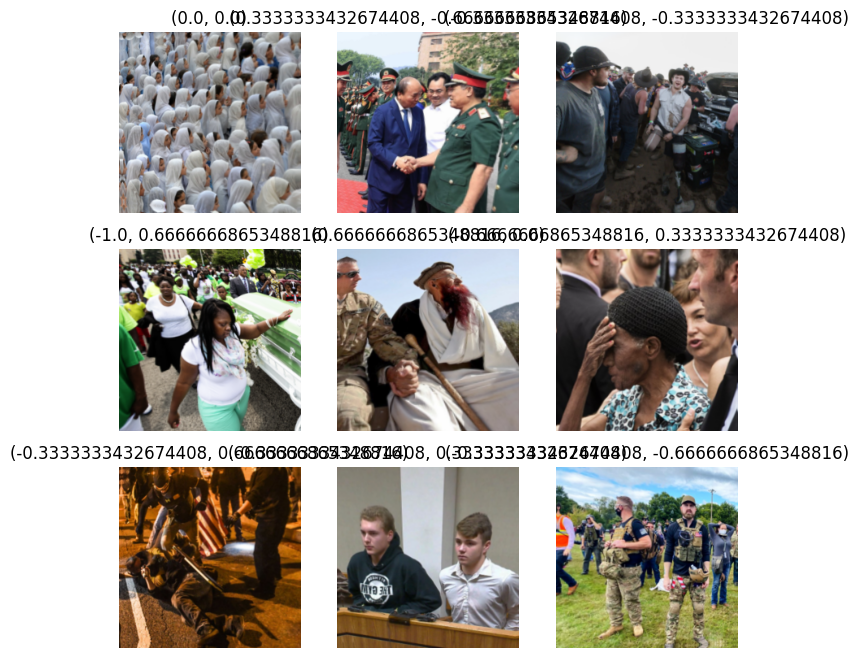

In [15]:
dls.show_batch(max_n=9, nrows=3, figsize=(8, 8))

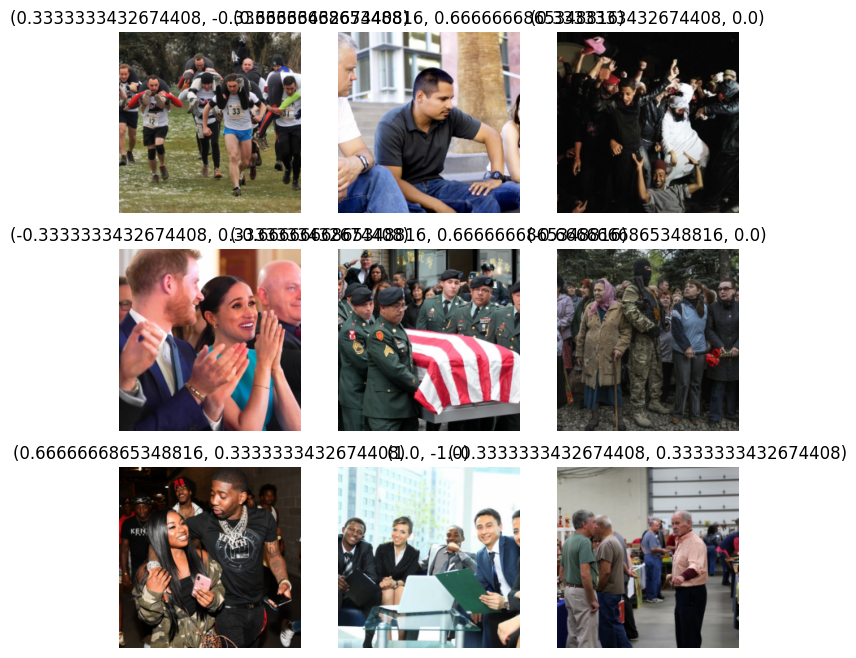

In [16]:
dls.valid.show_batch(max_n=9, nrows=3, figsize=(8, 8))

# Model: Frozen Backbone + tiny MLP head

In [17]:
class BackboneRegressor(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        feat_dim: int,
        hidden: int | None = None,
        p: float = 0.0,
    ):
        super().__init__()
        self.backbone = backbone
        if hidden and hidden > 0:
            self.head = nn.Sequential(
                nn.LayerNorm(feat_dim),
                nn.Dropout(p),
                nn.Linear(feat_dim, hidden),
                nn.GELU(),
                nn.Linear(hidden, 2),
                nn.Tanh(),
            )
        else:
            # Simple head: Linear -> Tanh (outputs in [-1, 1])
            self.head = nn.Sequential(
                nn.Linear(feat_dim, 2),
                nn.Tanh(),
            )
        # Ensure backbone is frozen
        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x: Tensor) -> Tensor:
        # x: pixel_values [B,3,H,W] already processor-normalized
        out = self.backbone(pixel_values=x)
        if hasattr(out, "pooler_output") and (out.pooler_output is not None):
            feats = out.pooler_output
        else:
            # CLS token (ViT) or spatial mean (ConvNeXt-like outputs)
            if hasattr(out, "last_hidden_state") and out.last_hidden_state.ndim == 3:
                feats = out.last_hidden_state[:, 0, :]
            else:
                # [B,C,H,W] -> global avg pool
                feats = out.last_hidden_state.mean(dim=(-1, -2))
        return self.head(feats)


model = BackboneRegressor(backbone, feat_dim, hidden=None, p=0.0).to(device)
model


BackboneRegressor(
  (backbone): TimmBackboneWrapper(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1),

In [18]:
# =======================
# Fastai metrics & loss
# =======================
def ccc_v(inp, targ):
    # Concordance Corr. Coefficient for Valence in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return ccc_fn(pred_fe[:, 0], targ_fe[:, 0])


def ccc_a(inp, targ):
    # Concordance Corr. Coefficient for Arousal in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return ccc_fn(pred_fe[:, 1], targ_fe[:, 1])


def ccc_avg(inp, targ):
    return (ccc_v(inp, targ) + ccc_a(inp, targ)) / 2


def mae_fe(inp, targ):
    # Report MAE in FE units (inverse-transformed)
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return torch.mean(torch.abs(pred_fe - targ_fe))


def mae_v_fe(inp, targ):
    # Valence MAE in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return torch.mean(torch.abs(pred_fe[:, 0] - targ_fe[:, 0]))


def mae_a_fe(inp, targ):
    # Arousal MAE in FE units
    pred_fe = ref_to_fe(inp)
    targ_fe = ref_to_fe(targ)
    return torch.mean(torch.abs(pred_fe[:, 1] - targ_fe[:, 1]))


# Use plain MSE loss in [-1,1] space for training
loss_func = nn.MSELoss()
# Report CCC and MAE during training/validation; Spearman is computed in the test block
metrics = [ccc_v, ccc_a, ccc_avg, mae_v_fe, mae_a_fe, mae_fe]


## Find Optimal LR

/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/Users/desmondchoy/Projects/emo-rec/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is en

Suggested LRs: 0.0005248074419796466 1.2022644114040304e-05


0.0005248074419796466

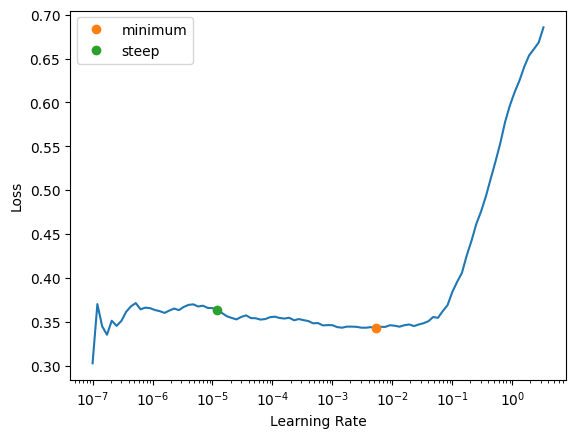

In [19]:
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    metrics=metrics,
    cbs=[CSVLogger(), EarlyStoppingCallback(patience=5)],
).to_fp16()

# Choose optimizer and hyperparameters (FastAI will create Adam by default)
# You can override like this:
learn.opt_func = partial(Adam, wd=1e-2)
# Find a good learning rate
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print("Suggested LRs:", lr_min, lr_steep)
lr = float(lr_min)
lr

## Fit One Cycle

In [20]:
learn.fit_one_cycle(EPOCHS, lr)

epoch,train_loss,valid_loss,ccc_v,ccc_a,ccc_avg,mae_v_fe,mae_a_fe,mae_fe,time
0,0.345527,0.330123,0.001634,-0.035795,-0.017081,1.556403,1.346202,1.451302,00:16
1,0.331477,0.317107,0.004329,-0.029847,-0.012759,1.498149,1.340533,1.419341,00:16
2,0.325350,0.318001,0.028137,-0.016897,0.005620,1.516454,1.343311,1.429882,00:16
3,0.321132,0.311531,0.059683,0.001871,0.030777,1.477541,1.358137,1.417839,00:16
4,0.314853,0.306011,0.087831,0.012234,0.050033,1.455724,1.347498,1.401611,00:16
5,0.309261,0.299638,0.115692,0.019281,0.067486,1.424408,1.340345,1.382376,00:16
6,0.302846,0.306190,0.118360,0.022936,0.070648,1.437404,1.359720,1.398562,00:16
7,0.297780,0.302250,0.134281,0.025981,0.080131,1.444912,1.334491,1.389702,00:16
8,0.292979,0.299941,0.148022,0.027062,0.087542,1.424462,1.336708,1.380585,00:16
9,0.290589,0.298246,0.145750,0.024750,0.085250,1.387667,1.339965,1.363816,00:16


No improvement since epoch 12: early stopping


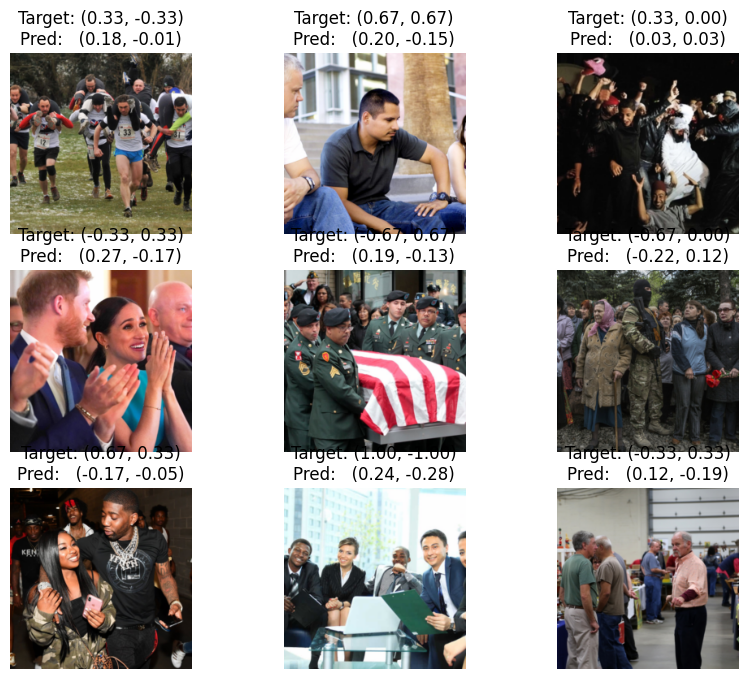

In [21]:
# Visualize predictions vs targets on the validation set
def _show_results_regression(learn, dl=None, max_n=9, nrows=3, figsize=(10, 8)):
    """A custom function to display regression results for image-to-point tasks."""
    import torch
    from fastai.vision.all import show_images

    # Use the validation dataloader if none is provided
    dl = dl or learn.dls.valid

    # Get one batch of data
    xb, yb = dl.one_batch()

    # Decode the batch to get human-readable inputs and targets
    xb_dec, yb_dec = dl.decode((xb, yb))

    # Get model predictions
    learn.model.eval()
    with torch.no_grad():
        preds = learn.model(xb.to(learn.dls.device)).cpu()

    # Prepare titles for the plots
    n = min(max_n, len(xb_dec))
    titles = []
    for i in range(n):
        # Flatten tensors and convert to list for easy formatting
        y = yb_dec[i].flatten().tolist()
        p = preds[i].flatten().tolist()
        titles.append(
            f"Target: ({y[0]:.2f}, {y[1]:.2f})\nPred:   ({p[0]:.2f}, {p[1]:.2f})"
        )

    # Use fastai's show_images to display the results
    show_images(xb_dec[:n], titles=titles, nrows=nrows, figsize=figsize)


# --- Directly call the working function ---
_show_results_regression(learn, max_n=9, figsize=(10, 8))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

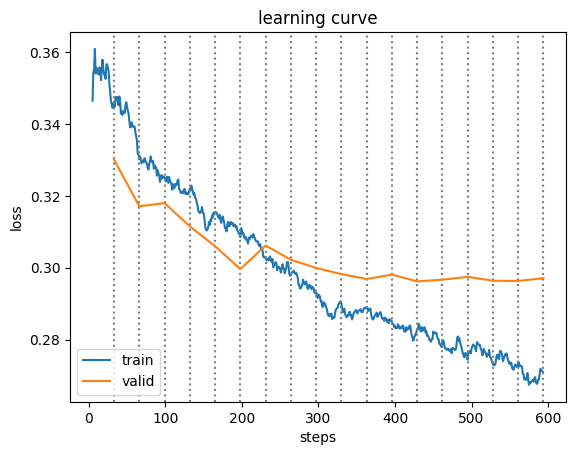

In [22]:
# Plot training/validation loss curves
learn.recorder.plot_loss(show_epochs=True)


Spearman’s ρ: Only calculated during test evaluation rather than as an epoch metric.

In [23]:
SCALE = 3.0  # both V and A scaled by 3 for bipolar space
SCALE_SQ = SCALE * SCALE  # 9.0


def _resolve_scale() -> float:
    """Return FE→unit scale; prefer SCALE, else sqrt(SCALE_SQ)."""
    try:
        return SCALE  # noqa: F821
    except NameError:
        return math.sqrt(SCALE_SQ)  # noqa: F821


def mae_fe_to_unit(mae_fe):
    """Convert FE-space MAE to ref-space [-1,1] MAE."""
    return float(mae_fe) / _resolve_scale()


In [24]:
mae_fe_to_unit(1.402860)

0.46762

# Evaluate on Test Set

In [25]:
# If your df_test actually contains the target columns:
# Optionally downsample test split for faster evaluation
df_test_eval = df_test
if DATA_FRACTION is not None and DATA_FRACTION < 1.0:
    df_test_eval = df_test.sample(
        frac=DATA_FRACTION, random_state=SAMPLE_SEED
    ).reset_index(drop=True)
test_dl = dls.test_dl(df_test_eval, with_labels=True)
test_metrics = learn.validate(dl=test_dl)

names = [
    "test_loss",  # MSE in [-1,1] training space
    "test_ccc_v",
    "test_ccc_a",
    "test_ccc_avg",
    "test_mae_v",
    "test_mae_a",
    "test_mae",  # MAE reported in FE units (see below for per-dim)
]
safe_metrics = [float(m) if m is not None else 0.0 for m in test_metrics]
res_basic = dict(zip(names, safe_metrics))

# Full-dataset MAE and Spearman's rho on FE units
preds_ref, targs_ref = learn.get_preds(dl=test_dl)
preds_fe = ref_to_fe(preds_ref.cpu())
targs_fe = ref_to_fe(targs_ref.cpu())

# MAE per-dimension and average
abs_err = torch.abs(preds_fe - targs_fe)
mae_v = abs_err[:, 0].mean().item()
mae_a = abs_err[:, 1].mean().item()
mae_avg = (mae_v + mae_a) / 2.0

from torchmetrics.functional import spearman_corrcoef as tm_spearman

rho_v = float(tm_spearman(preds_fe[:, 0].flatten(), targs_fe[:, 0].flatten()).cpu())
rho_a = float(tm_spearman(preds_fe[:, 1].flatten(), targs_fe[:, 1].flatten()).cpu())
rho_avg = (rho_v + rho_a) / 2.0

{
    **res_basic,
    "test_mae_v": mae_v,
    "test_mae_a": mae_a,
    "test_mae_avg": mae_avg,
    "test_spearman_v": rho_v,
    "test_spearman_a": rho_a,
    "test_spearman_avg": rho_avg,
}


{'test_loss': 0.30570754408836365,
 'test_ccc_v': 0.19795358180999756,
 'test_ccc_a': 0.03281661123037338,
 'test_ccc_avg': 0.11538510024547577,
 'test_mae_v': 1.4228838682174683,
 'test_mae_a': 1.388962745666504,
 'test_mae': 1.4059233665466309,
 'test_mae_avg': 1.405923306941986,
 'test_spearman_v': 0.3461722433567047,
 'test_spearman_a': 0.0717696025967598,
 'test_spearman_avg': 0.20897092297673225}

**Root cause**: CCC uses Pearson correlation; if predictions or targets have near‑zero variance, CCC’s denominator goes to zero and torchmetrics returns NaN with a warning.  

Above numbers corroborate this: test_loss measured in [-1,1] space scales to FE units by ×9 (since v→3v, a→3a). CCC NaN implies the model’s preds on the test set are (nearly) constant in at least one dim.

## Save head weights (state_dict) and full model if desired


In [26]:
SAVE_DIR = Path("./checkpoints")
SAVE_DIR.mkdir(exist_ok=True)
head_path = SAVE_DIR / "generic_head.pth"
torch.save(model.head.state_dict(), head_path)

# Optionally export the whole fastai Learner
# learn.export(SAVE_DIR/"learner.pkl")

head_path, head_path.exists()


(Path('checkpoints/generic_head.pth'), True)

# Inference helper (returns V,A in FE units)


# Export Learner for Inference

In [27]:
# 1) Remove file-writing callbacks
try:
    from fastai.callback.tensorboard import TensorBoardCallback
except Exception:
    TensorBoardCallback = None

to_remove = [CSVLogger] + ([TensorBoardCallback] if TensorBoardCallback else [])
learn.remove_cbs([cb for cb in to_remove if cb])

# 2) Aggressively null out any lingering file handles on remaining cbs
for cb in list(learn.cbs):
    for attr in ("file", "f", "writer"):
        if hasattr(cb, attr):
            try:
                getattr(cb, attr).close()
            except Exception:
                pass
            setattr(cb, attr, None)

# 3) Export to checkpoints under learn.path
SAVE_DIR = learn.path / "checkpoints"
SAVE_DIR.mkdir(parents=True, exist_ok=True)
learn.export(SAVE_DIR / "generic_model_learner.pkl")


## Load the exported learner and run inference on a single image


In [ ]:
# learner_path = Path("./checkpoints/generic_model_learner.pkl")
# learn_inf = load_learner(learner_path)  # loads on CPU by default
# # Optionally move to GPU if available in this session
# try:
#     learn_inf.dls.device = device
#     learn_inf.model.to(device)
# except Exception:
#     pass


# # Helper to resolve project-root relative image paths
# def resolve_from_root(p):
#     p = Path(p)
#     return p if p.is_absolute() else (PROJECT_ROOT / p)


# @torch.inference_mode()
# def predict_with_export(img_path: str | Path):
#     p = Path(img_path)
#     if not p.is_absolute():
#         p = resolve_from_root(p)
#     if not p.exists():
#         raise FileNotFoundError(f"Image not found: {p}")
#     img = PILImage.create(str(p))
#     pred_ref, _, _ = learn_inf.predict(img)
#     pred_ref_t = torch.as_tensor(pred_ref)
#     pred_fe = ref_to_fe(pred_ref_t.unsqueeze(0)).squeeze(0)
#     return pred_fe


# # Example: randomly sample one existing test image; show GT and prediction
# idxs = list(df_test.index)
# random.shuffle(idxs)
# for idx in idxs:
#     row = df_test.loc[idx]
#     p_abs = resolve_from_root(row["image_path"])
#     if p_abs.exists():
#         print("Using exported learner on:", p_abs)
#         display(PILImage.create(str(p_abs)))
#         print(f"Ground truth (V,A): ({row['valence']:.3f}, {row['arousal']:.3f})")
#         pred_va = predict_with_export(p_abs)
#         print(f"Predicted (V,A): ({pred_va[0].item():.3f}, {pred_va[1].item():.3f})")
#         break
# else:
#     raise FileNotFoundError("No existing paths found in df_test['image_path'].")
